In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import sys
import pathlib
from pathlib import Path
import pickle
import operator
import seaborn as sns
sns.set_style('white')
sys.setrecursionlimit(10000)
%matplotlib qt5

In [3]:
import cellbgnet
import cellbgnet.utils
from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.analyze_eval import *
from cellbgnet.analyze_eval import recognition, plot_full_img_predictions, assemble_full_img_predictions
import scipy.signal
import skimage.io as sio

In [4]:
from cellbgnet.utils.plot_funcs import plot_train_record

### Dataset and model paths

In [5]:
DATASET_PATH = Path('/mnt/sda1/SMLAT/data/real_data/membrane_dots/EXP-23-CA3095/exampleRun/Run/Pos01/fluor580/')

In [6]:
model_path = Path('/mnt/sda1/SMLAT/training_runs/model_rotated_45_venus_membrane.pkl')
with open(model_path, 'rb') as f:
    model = pickle.load(f)

In [7]:
plot_train_record(model)

### Load and plot data

In [8]:
venus_filenames = sorted(list(DATASET_PATH.glob('*.tiff')))

In [9]:
eval_images_all = []
for filename in venus_filenames:
    eval_images_all.append(sio.imread(filename))

In [10]:
eval_images_all = np.stack(eval_images_all)

In [11]:
eval_images_all.shape

(500, 500, 780)

In [12]:
np.mean(eval_images_all)

227.43238968205128

In [13]:
np.std(eval_images_all)

65.29011222554634

### Padding function

In [14]:
def padding_volume(image_volume, height_before, width_before, total_height=1041, total_width=1302):
    n_images, h, w = image_volume.shape
    #mean = int(np.mean(image_volume))
    #std = int(np.std(image_volume))
    mean = 240
    std = 30
    image_volume_padded = np.random.randint(low=mean-std, high=mean+std, size=(n_images, total_height, total_width))
    
    image_volume_padded[:, height_before:height_before+h, width_before:width_before + w] = image_volume
    return image_volume_padded

In [15]:
dataset_padded = padding_volume(eval_images_all, 100, 300)

In [16]:
dataset_padded.shape

(500, 1041, 1302)

In [112]:
plt.figure()
plt.imshow(dataset_padded[300])
plt.show()

#### Run inference and collect localizations

In [39]:
fov_size = [dataset_padded.shape[2] * 65, dataset_padded.shape[1] * 65]
plot_num = None
preds_raw, n_per_img, plot_area = recognition(model=model, eval_imgs_all=dataset_padded[150:, :, :],
                                              batch_size=32, use_tqdm=False,
                                     nms=True, candidate_threshold=0.3,
                                     nms_threshold=0.6,
                                     pixel_nm=model.data_generator.psf_params['pixel_size_xy'],
                                     plot_num=300,
                                     win_size=model.data_generator.simulation_params['train_size'],
                                     padding=True,
                                     padded_background=model.simulation_params['bg_values'])

processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278, 1301, 1021, 1040]


In [40]:
fov_size

[84630, 67665]

In [41]:
plot_full_img_predictions(model, plot_infs=plot_area, eval_csv=None,
                          plot_num=400, fov_size=fov_size,
                          pixel_size=[65, 65])

In [58]:
img_infs = assemble_full_img_predictions(model, plot_area)

In [59]:
img_infs.keys()

dict_keys(['Probs', 'XO', 'YO', 'ZO', 'Int', 'BG', 'XO_sig', 'YO_sig', 'ZO_sig', 'Int_sig', 'Probs_ps', 'XO_ps', 'YO_ps', 'ZO_ps', 'Samples_ps', 'raw_img', 'only_bg'])

In [60]:
for key, value in img_infs.items():
    plt.figure()
    plt.imshow(value[100: 600, 300:300+780])
    plt.colorbar()
    plt.title(key)
    plt.show()

In [54]:
x = [element[2] for element in preds_raw]
y = [element[3] for element in preds_raw]
z = [element[4] for element in preds_raw]

In [55]:
len(x)

63908

#### Plot in 3D

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:3000], y[:3000], z[:3000], marker='o')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

### Filter localizations and re-adjust origins

### Writing to CSV

In [63]:
preds_raw_np = np.array(preds_raw)

In [64]:
import csv

In [65]:
def write_csv(pred_list, name, write_gt=False, append=False, write_rescale=False):
    """Writes a csv_file with columns: 'localizatioh', 'frame', 'x', 'y', 'z', 'intensity','x_sig','y_sig','z_sig'
    
    Parameters
    ----------
    pred_list : list
        List of localizations
    name: str
        File name
    """
    if write_gt:
        with open(name, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow(['x_gt', 'y_gt', 'z_gt', 'intensity_gt', 'x_pred', 'y_pred', 'z_pred',
                                'intensity_pred', 'nms_p', 'x_sig', 'y_sig', 'z_sig'])
            for p in pred_list:
                csvwriter.writerow([repr(f) for f in p])
    else:
        if not append:
            if not write_rescale:
                with open(name, 'w', newline='') as csvfile:
                    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                    csvwriter.writerow(['Ground-truth', 'frame', 'xnm', 'ynm', 'znm', 'intensity', 'nms_p', 'x_sig',
                                        'y_sig', 'z_sig', 'I_sig','xo','yo'])
                    for p in pred_list:
                        csvwriter.writerow([repr(f) for f in p])
            else:
                with open(name, 'w', newline='') as csvfile:
                    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                    csvwriter.writerow(['Ground-truth', 'frame', 'xnm', 'ynm', 'znm', 'intensity', 'nms_p', 'x_sig',
                                        'y_sig', 'z_sig', 'I_sig','xo','yo','xo_rescale','yo_rescale','xnm_rescale','ynm_rescale'])
                    for p in pred_list:
                        csvwriter.writerow([repr(f) for f in p])
        else:
            with open(name, 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                for p in pred_list:
                    csvwriter.writerow([repr(f) for f in p])

In [66]:
SAVE_CSV_PATH = '/mnt/sda1/SMLAT/data/real_data/membrane_dots/EXP-23-CA3095/plotting_outputs/example_run.csv'
write_csv(preds_raw, name=SAVE_CSV_PATH, write_gt=False, append=True, write_rescale=False)

In [93]:
import pandas as pd

In [94]:

def read_csv(path, flip_z=False, z_fac=1, pix_scale=[1, 1], drift_txt=None):
    """Reads a csv_file with leading columns: 'localization', 'frame', 'x', 'y', 'z'
    
    Parameters
    ----------
    flip_z : bool
        If True flips the z variable
    z_fac: float
        Multiplies z variable with the given factor to correct for eventual aberrations
    pix_scale: list of two ints
        Multiplies x and y locations with the given factors
    drift_txt : str
        Reads a drift corredtion txt file and applies drift correction for x and y locations
        
    Returns
    -------
    preds :list
        List of localizations with x,y,z locations given in nano meter
    """
    preds = pd.read_csv(path, header=None, skiprows=[0]).values

    if drift_txt is not None:
        drift_data = pd.read_csv(drift_txt, sep='	', header=None, skiprows=0).values

        for p in preds:
            p[2] = float(p[2]) - 100 * drift_data[np.clip(int(p[1]) - 1, 0, len(drift_data) - 1), 1]
            p[3] = float(p[3]) - 100 * drift_data[np.clip(int(p[1]) - 1, 0, len(drift_data) - 1), 2]

    preds[:, 2] = preds[:, 2] * pix_scale[0] + 0
    preds[:, 3] = preds[:, 3] * pix_scale[1] + 0
    preds[:, 4] = preds[:, 4] * z_fac + 0
    if flip_z:
        preds[:, 4] = -preds[:, 4] + 0

    return preds

In [95]:
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
import PIL
from PIL import ImageEnhance
from PIL import ImageTk
import cv2

In [96]:

def create_3d_hist(preds, z_clip=None, pix_size=5, sigma=3, contrast_fac=10, clip_density=100):
    """Produces a coloured histogram to display 3D reconstructions.
    
    Parameters
    ----------
    preds: list
        List of localizations with columns: 'localization', 'frame', 'x', 'y', 'z'
    z_clip: list of ints
        Clips the the z values at the given lower and upper limit to control the colorrange. 
    pix_size: float
        Size of the pixel (nano meter) in the reconstruction plot
    sigma:
        Size of Gaussian used for blurring
    constrast fact: float
        Contrast can be scaled with this variable if the output image is to bright/dark
    clip_density: float 
        Percentile between 0 and 100. Artifacts that produce extremely dense regions in the histrogram can 
        mess up the contrast scaling. This parameter can be used to exclude the brightest regions. 
        
    Returns
    -------
    Image: PIL image
        Coloured histogram of 3D reconstruction
    """
    # adjust colormap
    lin_hue = np.linspace(0, 1, 256)
    cmap = plt.get_cmap('jet', lut=256);
    cmap = cmap(lin_hue)
    cmap_hsv = rgb_to_hsv(cmap[:, :3])
    storm_hue = cmap_hsv[:, 0]
    _, b = np.unique(storm_hue, return_index=True)
    storm_hue = [storm_hue[index] for index in sorted(b)]
    n_val = len(storm_hue)
    storm_hue = np.interp(np.linspace(0, n_val, 256), np.arange(n_val), storm_hue)

    x_pos = np.clip(np.array(preds)[:, 2], 0, np.inf)
    y_pos = np.clip(np.array(preds)[:, 3], 0, np.inf)
    z_pos = np.array(preds)[:, 4]

    min_z = min(z_pos)
    max_z = max(z_pos)

    if z_clip is not None:
        z_pos[z_pos < z_clip[0]] = z_clip[0]
        z_pos[z_pos > z_clip[1]] = z_clip[1]
        zc_val = (z_pos - z_clip[0]) / (z_clip[1] - z_clip[0])

    else:
        zc_val = (z_pos - min_z) / (max_z - min_z)

    z_hue = np.interp(zc_val, lin_hue, storm_hue)

    nx = int((np.max(x_pos)) // pix_size + 1)
    ny = int((np.max(y_pos)) // pix_size + 1)
    dims = (nx, ny)

    x_vals = np.array(x_pos // pix_size, dtype='int')
    y_vals = np.array(y_pos // pix_size, dtype='int')

    lin_idx = np.ravel_multi_index((x_vals, y_vals), dims)
    density = np.bincount(lin_idx, weights=np.ones(len(lin_idx)), minlength=np.prod(dims)).reshape(dims)
    density = np.clip(density, 0, np.percentile(density, clip_density))
    zsum = np.bincount(lin_idx, weights=z_hue, minlength=np.prod(dims)).reshape(dims)
    zavg = zsum / density
    zavg[np.isnan(zavg)] = 0

    hue = zavg[:, :, None]
    sat = np.ones(density.shape)[:, :, None]
    val = (density / np.max(density))[:, :, None]
    sr_HSV = np.concatenate((hue, sat, val), 2)
    sr_RGB = hsv_to_rgb(sr_HSV)
    # %have to gaussian blur in rgb domain
    sr_RGBblur = cv2.GaussianBlur(sr_RGB, (11, 11), sigma / pix_size)
    sr_HSVblur = rgb_to_hsv(sr_RGBblur)

    val = sr_HSVblur[:, :, 2]

    sr_HSVfinal = np.concatenate((sr_HSVblur[:, :, :2], val[:, :, None]), 2)
    sr_RGBfinal = hsv_to_rgb(sr_HSVfinal)

    sr_Im = PIL.Image.fromarray(np.array(np.round(sr_RGBfinal * 256), dtype='uint8'))
    enhancer = ImageEnhance.Contrast(sr_Im)
    sr_Im = enhancer.enhance(contrast_fac)

    return sr_Im.transpose(PIL.Image.TRANSPOSE)

In [97]:
preds_raw_reread = read_csv(SAVE_CSV_PATH).tolist()

In [98]:
hist_img_roi1 = create_3d_hist(preds_raw_reread, z_clip=[-500, 500], pix_size=65, sigma=10, contrast_fac=100)

/tmp/ipykernel_459530/23592065.py:64: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density


In [101]:
plt.figure()
plt.imshow(hist_img_roi1)
plt.show()

In [100]:
preds_raw_reread

[[5.0,
  1.0,
  24248.009765625,
  10074.1181640625,
  -33.848575592041016,
  2137.09130859375,
  0.8957968950271606,
  19.631261825561523,
  16.603944778442383,
  63.90219497680664,
  282.2428283691406,
  0.0462994091212749,
  -0.013569843955338],
 [7.0,
  1.0,
  24676.939453125,
  13173.5419921875,
  -58.13550567626953,
  2803.843017578125,
  0.8673930168151855,
  11.04676914215088,
  12.720685958862305,
  40.19956588745117,
  199.37901306152344,
  -0.3547628819942474,
  -0.3301211595535278],
 [8.0,
  1.0,
  24375.8828125,
  15556.80078125,
  -49.31761932373047,
  1842.25,
  0.7714390158653259,
  19.18744468688965,
  17.375356674194336,
  65.24109649658203,
  214.6817321777344,
  0.0135846678167581,
  0.3353933990001678],
 [9.0,
  1.0,
  23686.763671875,
  15933.5634765625,
  -643.79345703125,
  2016.4189453125,
  0.712185263633728,
  23.04842185974121,
  24.26114845275879,
  28.29348564147949,
  240.63385009765625,
  0.4117348194122314,
  0.1317420005798339],
 [10.0,
  1.0,
  23971.

In [104]:
hist_img_roi1.size

(1087, 609)

### Filtered based on X and Y

In [126]:
xy_filtered = []
for localization in preds_raw_reread:
    if localization[2] > 555 * 65 and localization[2] < 1050 * 65 and localization[3] > 240 * 65 and localization[3] < 280 * 65:
        xy_filtered.append(localization)

In [127]:
len(xy_filtered)

5024

In [128]:
hist_img_roi2 = create_3d_hist(xy_filtered, z_clip=[-500, 500], pix_size=65, sigma=10, contrast_fac=100)

/tmp/ipykernel_459530/23592065.py:64: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density


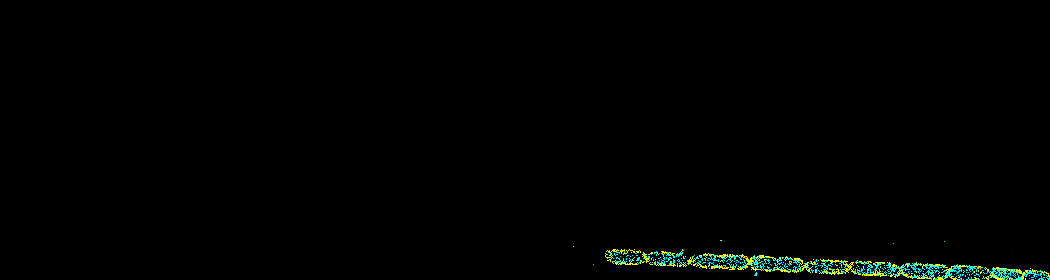

In [129]:
hist_img_roi2

In [130]:
x = [element[2] for element in xy_filtered]
y = [element[3] for element in xy_filtered]
z = [element[4] for element in xy_filtered]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, marker='o', alpha=0.3)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.axis('equal')
plt.show()